# Impact of static imperfections on our X-band linac from 100 MeV to 500 MeV and beam-based alignment

In [1]:
%plot -f SVG

In [2]:
RF_Track;


RF-Track, version 2.2.3

Copyright (C) 2016-2024 CERN, Geneva, Switzerland. All rights reserved.

Author and contact:
 Andrea Latina <andrea.latina@cern.ch>
 BE-ABP Group
 CERN
 CH-1211 GENEVA 23
 SWITZERLAND

This software is distributed under a CERN proprietary software
license in the hope that it will be useful, but WITHOUT ANY WARRANTY;
not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

See the COPYRIGHT and LICENSE files at the top-level directory of
the RF-Track download area: https://gitlab.cern.ch/rf-track/download

RF-Track was compiled with GSL-2.7 and fftw-3.3.10



## Load the lattice from appropriate scripts

In [3]:
addpath('scripts/')

## Let's define some key parameters
We use a structure to collect all relevant parameters

In [4]:
%% Structure "setup"
setup.Q = -1; % single-particle charge, in units of e
setup.mass = RF_Track.electronmass; % MeV/c^2
setup.population = RF_Track.nC; % 50 * RF_Track.pC; % number of real particles per bunch
setup.sigma_t = 0.100; % mm/c
setup.sigma_pt = 0.1; % permil
setup.P_i = 100; % initial momentum, MeV/c
setup.P_f = 500; % final momentum, MeV/c
setup.phid = -27; % deg, phase of the RF structures
setup.mu = 60; % deg, FODO phase advance per cell

## Let's build the linac lattice
We use a standard FODO lattice, with four structures every two consecutive quadrupoles and 90 degrees phase advance per cell

In [5]:
LINAC = init_linac_lattice (setup);

P_i = 100
P_f = 500
n_FODO = 5


## Let's define and track the reference particle

In [6]:
P0 = init_reference_particle (setup);

% Track the reference particle
P1 = LINAC.track(P0);

In [7]:
P1.get_phase_space()

ans =

            0            0            0            0   9.5283e+03   5.1805e+02



In [8]:
LINAC.get_length()

ans = 9.5283


In [9]:
format long
P0.get_phase_space('%Vx %Vy %Vz')
P1.get_phase_space('%Vx %Vy %Vz')

ans =

                   0                   0   0.999986944259338

ans =

                   0                   0   0.999999513510324



## ...and a bunch

In [10]:
B0 = init_bunch(setup);

## Let's study the impact of quadrupole misalignment

Assuming 100 $\mu$m and 100 $\mu$rad RMS pre-alignment error

In [11]:
sigma_X = 0.100; % mm
sigma_ROLL = 0.100; % mrad

We use the method: ```LINAC.scatter_elements``` which takes
* type of element
* X, Y, Z rms misalignment in mm
* ROLL, PITCH, YAW rms misalignemnt in mrad
* the reference point: 'entrance',  'center',  'exit'

Let's simulate a few random seeds...

Seed 1/10
Seed 2/10
Seed 3/10
Seed 4/10
Seed 5/10
Seed 6/10
Seed 7/10
Seed 8/10
Seed 9/10
Seed 10/10


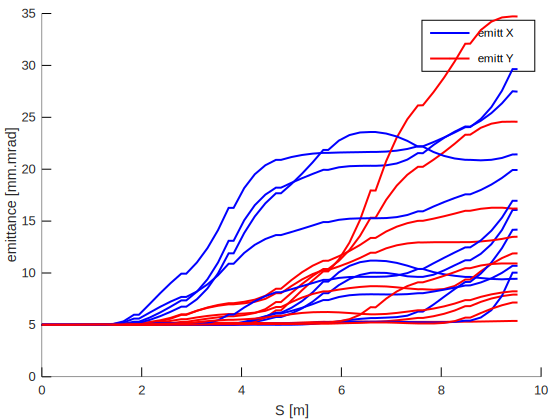

In [12]:
nSeeds = 10;

for i=1:nSeeds

    printf('Seed %d/%d\n', i, nSeeds);

    LINAC.scatter_elements('quadrupole', sigma_X, sigma_X, 0, sigma_ROLL, 0, 0, 'center');

    B1 = LINAC.track(B0);

    T = LINAC.get_transport_table('%S %emitt_x %emitt_y');
    
    hold on
    plot(T(:,1), T(:,2), 'b-', 'linewidth', 2);
    plot(T(:,1), T(:,3), 'r-', 'linewidth', 2);
    legend({'emitt X', 'emitt Y'});
    xlabel('S [m]');
    ylabel('emittance [mm.mrad]');

end

## Let's misalign the RF structures

Seed 1/10
Seed 2/10
Seed 3/10
Seed 4/10
Seed 5/10
Seed 6/10
Seed 7/10
Seed 8/10
Seed 9/10
Seed 10/10


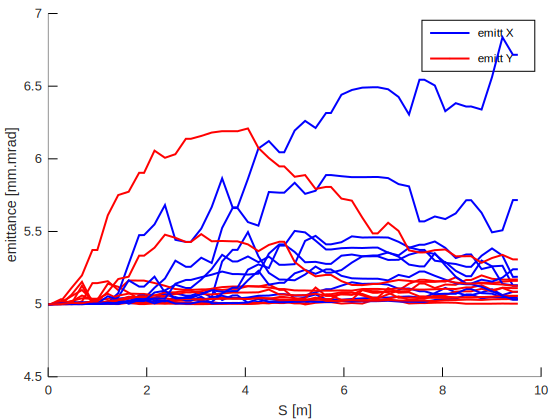

In [13]:
nSeeds = 10;

LINAC.align_elements(); % zeros the offsets of all the elements

for i=1:nSeeds

    printf('Seed %d/%d\n', i, nSeeds);

    LINAC.scatter_elements('rf_element', sigma_X, sigma_X, 0, sigma_ROLL, 0, 0, 'center');

    B1 = LINAC.track(B0);

    T = LINAC.get_transport_table('%S %emitt_x %emitt_y');
    
    hold on
    plot(T(:,1), T(:,2), 'b-', 'linewidth', 2);
    plot(T(:,1), T(:,3), 'r-', 'linewidth', 2);
    legend({'emitt X', 'emitt Y'});
    xlabel('S [m]');
    ylabel('emittance [mm.mrad]');

end


In [14]:
%LINAC.get_elements_offsets()

## Let's apply orbit correction

### We need to add correctors and bpms to our lattice

In [15]:
LINAC_BBA = init_linac_lattice_bba (setup);

P_i = 100
P_f = 500
n_FODO = 5


In [16]:
R0 = LINAC_BBA.get_response_matrix (B0);

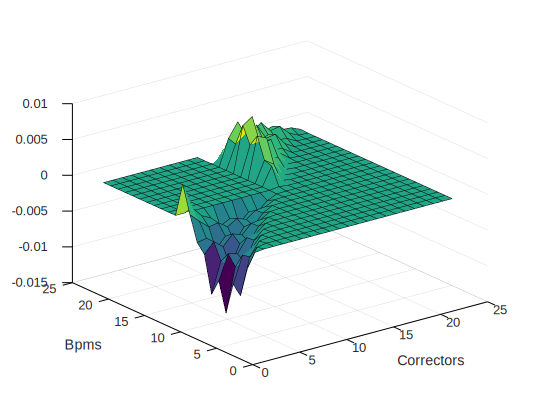

In [17]:
surf(R0);
xlabel('Correctors')
ylabel('Bpms')

We use the method ```LINAC_BBA.orbit_correction(R0, B0, threshold)```
* The response matrix
* The incoming beam
* threshold is a cut applied to the singular values of the reponse matrix relative to the largest singular value

Seed 1/10
Seed 2/10
Seed 3/10
Seed 4/10
Seed 5/10
Seed 6/10
Seed 7/10
Seed 8/10
Seed 9/10
Seed 10/10


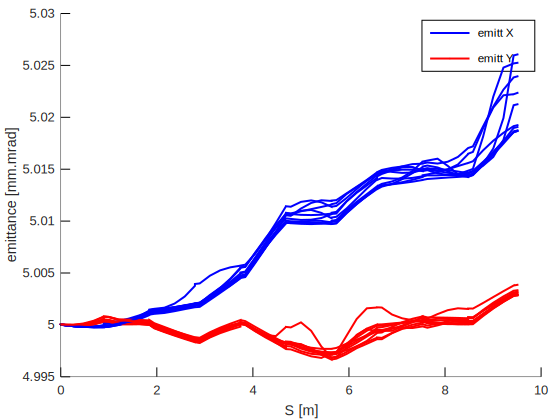

In [18]:
nSeeds = 10;

LINAC_BBA.align_elements(); % zeros the offsets of all the elements

for i=1:nSeeds

    printf('Seed %d/%d\n', i, nSeeds);

    LINAC_BBA.scatter_elements('quadrupole', sigma_X, sigma_X, 0, sigma_ROLL, 0, 0, 'center');
    LINAC_BBA.reset_correctors();
    
    %LINAC_BBA.track(B0);
    LINAC_BBA.orbit_correction(R0, B0, 0.01); 

    T = LINAC_BBA.get_transport_table('%S %emitt_x %emitt_y');
    
    hold on
    plot(T(:,1), T(:,2), 'b-', 'linewidth', 2);
    plot(T(:,1), T(:,3), 'r-', 'linewidth', 2);
    legend({'emitt X', 'emitt Y'});
    xlabel('S [m]');
    ylabel('emittance [mm.mrad]');

end

The correction is extremely effective!

We can get the corrector strengths using the method ```LINAC_BBA.get_correctors_strengths()```, which returns T*mm

In [19]:
LINAC_BBA.get_correctors_strengths()

ans =

  -9.135388427748797e+00  -2.136813072720704e+01
  -6.726297395539477e+01   1.961491272932772e+01
  -1.324591726904364e+01  -3.366533930268246e+01
   6.013975483725000e+01   6.310466928686494e+01
   3.933220131766210e+01   1.987721332147189e+01
   2.055907603367470e+01   2.870691806761537e+01
   7.693911599863732e+01  -6.110981769188037e+00
   7.255374101824236e+01  -8.992559200997668e+00
   1.194448084218236e+02   9.949743285890571e+01
   4.107829597626734e+01   2.430537485961260e+02
   3.582266246861590e+00   2.385483854704977e+01



## Dispersion-Free Steering
We change the RF phase to send a test beam with an energy different from the nominal. Dispersion-free steering aims to have nominal and test beams pass through the same BPM positions.

\begin{equation*}
\left(
\begin{array}{rl}
 & \mathbf{b}\\
\omega_d & \left(\mathbf{b}_1-\mathbf{b}\right)\\
% & \mathbf{0}
\end{array}
\right)=
\left(
\begin{array}{rl} & \mathbf{R_0}\\
\omega_d & \left(\mathbf{R_1} - \mathbf{R_0}\right)\\
%\omega_w & \mathbf{W}\\
%\beta & \mathbf{I}
\end{array}\right)\boldsymbol{\theta}.
\end{equation*}

Given a measured orbit and dispersive trajectory, the system of equations provides the correcting correctors' settings:
\begin{equation*}
\Delta\boldsymbol{\theta}=-\left(\begin{array}{rl}
 & \mathbf{R_{0}}\\
\omega_{d} & \left(\mathbf{R_{1}}-\mathbf{R_{0}}\right),
\end{array}\right)^{-1}\left(\begin{array}{rl}
 & \mathbf{b}\\
\omega_{d} & \left(\mathbf{b}_{1}-\mathbf{b}\right)
\end{array}\right),
\end{equation*}
where $\left(\,\cdots\,\right)^{-1}$ denotes the pseudo-inverse of the matrix.

In [20]:
function change_linac_phase(LINAC, phid)
    RF_Track;
    % set the phase of all structures
    RF = LINAC.get_rf_elements();
    RF{1}.set_phid(phid);
end

In [21]:
change_linac_phase (LINAC_BBA, 0);

R1 = LINAC_BBA.get_response_matrix (B0);

change_linac_phase (LINAC_BBA, setup.phid);

Let's store the 4d emittance for the uncorrected machine, the orbit-corrected, and the dispersion-corrected (usually, one would look at emittance in X and Y separately; however, here for simplicity, we look at the emittance 4d).

In [22]:
sigma_X = 0.100; % mm
sigma_Xbpms = 0.020; % mm

nSeeds = 10;

LINAC_BBA.align_elements(); % zeros the offsets of all the elements

wgt = 10; % weighting factor between orbit and dispersion correction
R = [   R0 
        wgt * (R1 - R0) ];

T_Emt_U = []; % uncorrected
T_Emt_O = []; % orbit-corrected
T_Emt_D = []; % dispersion-corrected

for i=1:nSeeds

    printf('Seed %d/%d\n', i, nSeeds);

    LINAC_BBA.scatter_elements('quadrupole', sigma_X, sigma_X, 0, 0, 0, 0, 'center');
    LINAC_BBA.scatter_elements('rf_element', sigma_X, sigma_X, 0, 0, 0, 0, 'center');
    LINAC_BBA.scatter_elements('bpm', sigma_Xbpms, sigma_Xbpms, 0, 0, 0, 0, 'center');
    LINAC_BBA.reset_correctors();

    disp('Uncorrected machine...')
    LINAC_BBA.track(B0);
    
    T_Emt_U = [ T_Emt_U ; LINAC_BBA.get_transport_table('%emitt_4d')' ];
    
    %% Orbit correction
    disp('Orbit correction...')
    LINAC_BBA.orbit_correction(R0, B0, 0.01);
    
    T_Emt_O = [ T_Emt_O ; LINAC_BBA.get_transport_table('%emitt_4d')' ];
    
    %% Dispersion correction
    disp('Dispersion correction...')
    
    Bpm0 = LINAC_BBA.get_bpm_readings();

    % Track the test beam
    change_linac_phase (LINAC_BBA, 0);
    LINAC_BBA.track (B0);
    change_linac_phase (LINAC_BBA, setup.phid);

    % Get the dispersive orbit
    Bpm1 = LINAC_BBA.get_bpm_readings();

    % Prepare for the correction computation
    Bpm0 = Bpm0(:); % transform into 1-column vector
    Bpm1 = Bpm1(:);

    % Compute correction
    B = [ Bpm0 ; wgt * (Bpm1 - Bpm0) ];
    C = -pinv(R, 0.01) * B; 
    
    % C is a vector containing 2*Ncorrectors items
    C = reshape (C, rows(C)/2, 2); % We need to convert it in a 2-column matrix with Ncorrectors rows.

    % Apply the correction
    LINAC_BBA.vary_correctors_strengths(C);

    % Track the beam to get the emittance
    LINAC_BBA.track(B0);
    T_Emt_D = [ T_Emt_D ; LINAC_BBA.get_transport_table('%emitt_4d')' ];
    
end

Seed 1/10
Uncorrected machine...
Orbit correction...
Dispersion correction...
Seed 2/10
Uncorrected machine...
Orbit correction...
Dispersion correction...
Seed 3/10
Uncorrected machine...
Orbit correction...
Dispersion correction...
Seed 4/10
Uncorrected machine...
Orbit correction...
Dispersion correction...
Seed 5/10
Uncorrected machine...
Orbit correction...
Dispersion correction...
Seed 6/10
Uncorrected machine...
Orbit correction...
Dispersion correction...
Seed 7/10
Uncorrected machine...
Orbit correction...
Dispersion correction...
Seed 8/10
Uncorrected machine...
Orbit correction...
Dispersion correction...
Seed 9/10
Uncorrected machine...
Orbit correction...
Dispersion correction...
Seed 10/10
Uncorrected machine...
Orbit correction...
Dispersion correction...


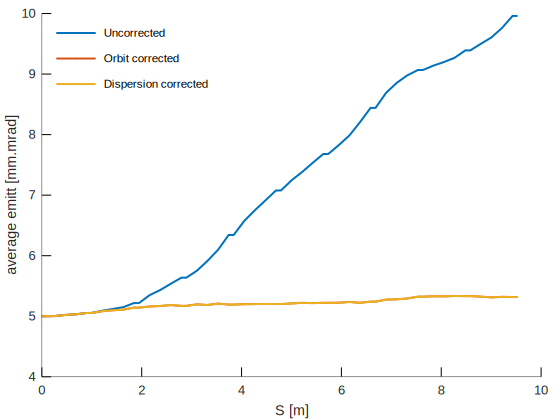

In [23]:
S = LINAC_BBA.get_transport_table('%S');

figure
hold on
plot(S, mean(T_Emt_U), 'linewidth', 2);
plot(S, mean(T_Emt_O), 'linewidth', 2);
plot(S, mean(T_Emt_D), 'linewidth', 2);
xlabel('S [m]')
ylabel('average emitt [mm.mrad]');
legend({'Uncorrected', 'Orbit corrected', 'Dispersion corrected'}, 'location', 'northwest', 'box', 'off');